# Kalman Filter Pairs Trading

Kalman filters are a medium-frequency strategy that estimate time-varying relationships between dual stocks. The objective is to dynamically update the hedge ratio $\beta$ .

Using daily close data is cleaner and less noisy than intraday ticks, and is a realistic trading frequency for stat arb.

I will calibrate the noise parameters (delta, v_t) on data from 2017-04-18 to 2022-04-14, and then backtest the strategy from 2022-04-18 to 2025-04-18. Notably, the train window includes the COVID-19 market crash, and the test window includes the 'Liberation Day' Tariffs on 2025-04-02. This was conducted on 2025-04-19.
https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

dbs = pd.read_csv("dbs_7y.csv")
uob = pd.read_csv("uob_7y.csv")

index_2022_04_18 = dbs[dbs["Date"].str.startswith("2022-04-18")].index[0]
dbs = dbs.set_index("Date")
uob = uob.set_index("Date")
dbs_train = dbs.iloc[:index_2022_04_18]
uob_train = uob.iloc[:index_2022_04_18]
dbs_test = dbs.iloc[index_2022_04_18:]
uob_test = uob.iloc[index_2022_04_18:]


static_beta = 1.503825291 # hedge ratio from part 02

In [60]:
def calculate_kalman(array1, array2, delta):
    trans_cov = delta / (1-delta) * np.eye(2)
    obs_mat = np.vstack([array1, np.ones(len(array1))]).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[0, 0],
        initial_state_covariance=np.eye(2),
        transition_matrices = np.eye(2),
        observation_matrices = obs_mat,
        observation_covariance = 1,
        transition_covariance = trans_cov
    )

    means, covs = kf.filter(array2)
    return means, covs

In [68]:
def kalman_filter(series1, series2, delta):
    state_means, state_covs = calculate_kalman(series1.values, series2.values, delta)

    pd.DataFrame(
            dict(
                slope=state_means[:, 0], 
                intercept=state_means[:, 1]
            ), index=series1.index
        ).plot(subplots=True)
    plt.xticks(rotation=45)
    plt.show()

    spread_kalman = series2 - (state_means[:, 0] * series1 + state_means[:, 1])
    spread_kalman.plot(title="Kalman Filter Model Spread")
    plt.xticks(rotation=45)
    plt.show()

    rolling_mean = pd.Series(spread_kalman).rolling(30).mean()
    rolling_std = pd.Series(spread_kalman).rolling(30).std()
    zscore_kalman = (spread_kalman - rolling_mean) / (rolling_std + 1e-6)
    zscore_kalman.plot(title="Z-Score of Kalman Filter Spread")
    plt.xticks(rotation=45)
    plt.show()

    return state_means, state_covs


(1259,)


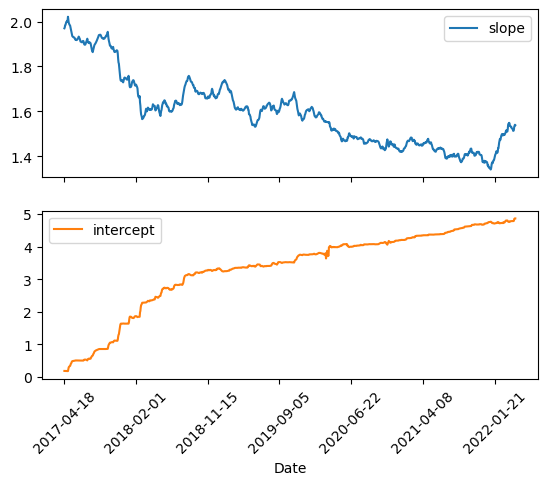

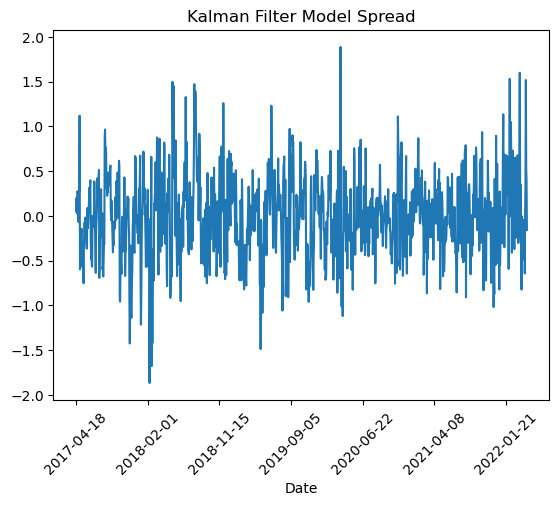

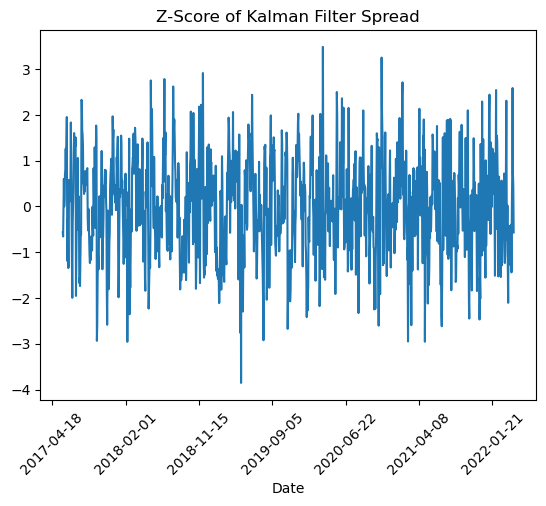

In [106]:
array1 = dbs_train['Close']# - dbs_train['Close'].mean()
array2 = uob_train['Close']# - uob_train['Close'].mean()
print(array1.shape)
state_means, state_covs = kalman_filter(array1, array2, 1e-4)

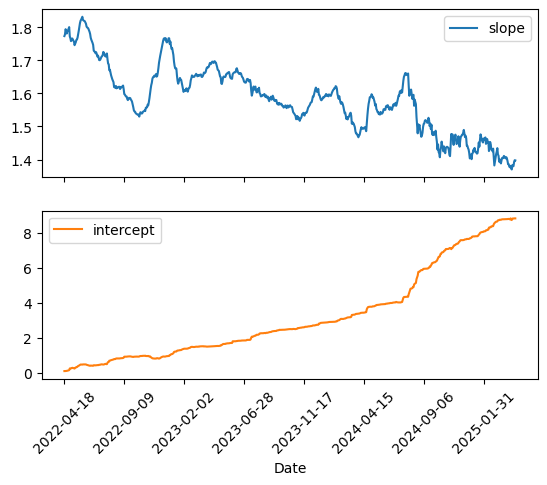

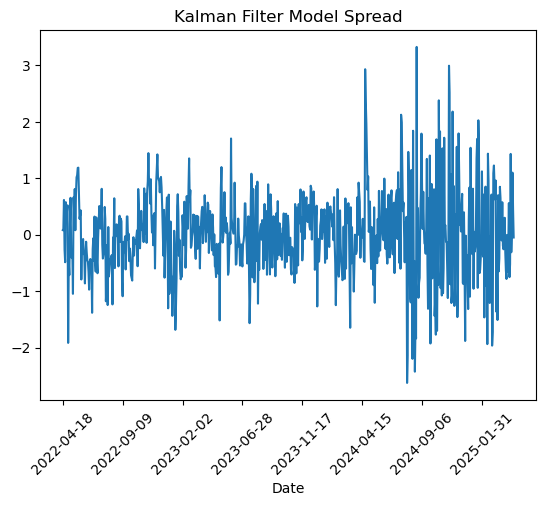

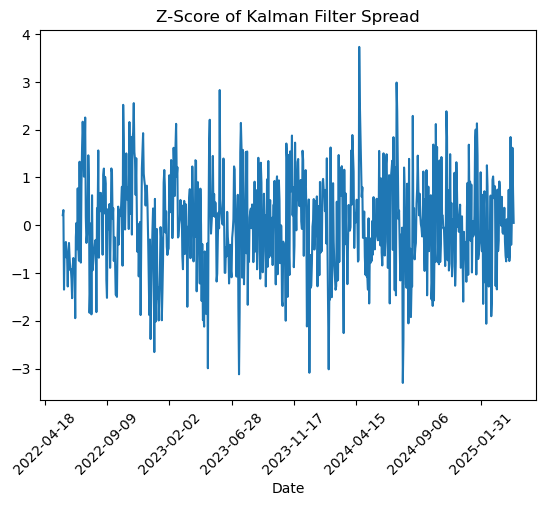

In [107]:
array1 = dbs_test['Close']# - dbs_test['Close'].mean()
array2 = uob_test['Close']# - uob_test['Close'].mean()
state_means_test, state_covs_test = kalman_filter(array1, array2, 1e-4)